In [1]:
#Data Manipulation
import pandas as pd
import numpy as np

# Plots
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

#Others
import os
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose

# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt


In [2]:
ruta_data = "..\\data\\data_casal_montserratina\\LaMonserratina_CLEAN.csv"

In [3]:
df = pd.read_csv(ruta_data)
df.head()

,Date,temperature_2m_C,relative_humidity_2m_%,dew_point_2m_C,apparent_temperature_C,pressure_msl_hPa,surface_pressure_hPa,cloud_cover_%,cloud_cover_high_%,et0_fao_evapotranspiration_mm,...,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,DayOfYear_sin,DayOfYear_cos,isHoliday,Season
0,2022-07-02 00:00:00,20.259000,84.817234,17.602751,22.359378,1020.012500,1014.212769,0.5625,0.000,0.00000,...,-0.2588,0.9659,-0.4339,-0.901,0.0,-1.0,0.0086,-1.0,False,2
1,2022-07-02 01:00:00,19.277750,89.401823,17.490251,21.180619,1019.587522,1013.770798,0.0000,0.000,0.00000,...,0.0000,1.0000,-0.4339,-0.901,0.0,-1.0,0.0086,-1.0,False,2
2,2022-07-02 02:00:00,19.715250,88.562090,17.771502,21.657682,1019.212500,1013.406601,0.0000,0.000,0.00000,...,0.2588,0.9659,-0.4339,-0.901,0.0,-1.0,0.0086,-1.0,False,2
3,2022-07-02 03:00:00,19.759000,88.008093,17.715251,21.494984,1018.787500,1012.984924,0.0000,0.000,0.00000,...,0.5000,0.8660,-0.4339,-0.901,0.0,-1.0,0.0086,-1.0,False,2
4,2022-07-02 04:00:00,19.609001,88.203276,17.602750,21.462321,1018.562487,1012.758133,4.8375,16.125,0.00631,...,0.7071,0.7071,-0.4339,-0.901,0.0,-1.0,0.0086,-1.0,False,2


In [4]:
df.columns

Index(['Date', 'temperature_2m_C', 'relative_humidity_2m_%', 'dew_point_2m_C',
       'apparent_temperature_C', 'pressure_msl_hPa', 'surface_pressure_hPa',
       'cloud_cover_%', 'cloud_cover_high_%', 'et0_fao_evapotranspiration_mm',
       'vapour_pressure_deficit_kPa', 'wind_speed_10m_km/h',
       'wind_direction_10m_º', 'wind_gusts_10m', 'is_day',
       'sunshine_duration_sec', 'shortwave_radiation_W/m2',
       'direct_radiation_W/m2', 'diffuse_radiation_W/m2',
       'direct_normal_irradiance_W/m2', 'global_tilted_irradiance_W/m2',
       'terrestrial_radiation_W/m2', 'Temp_interna_Modulo_C', 'Demanda_kWh',
       'Year', 'Month', 'Hour', 'DayOfWeek', 'DayOfYear', 'isWeekend',
       'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin',
       'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos', 'isHoliday', 'Season'],
      dtype='object')

In [5]:
df["Date"] = pd.to_datetime(df["Date"])
df = df[["Date", "Demanda_kWh"]]
df.rename(columns={'Date': 'ds', 
                   'Demanda_kWh': 'y'}, inplace=True)
df.head()

,ds,y
0,2022-07-02 00:00:00,3.000000
1,2022-07-02 01:00:00,2.000000
2,2022-07-02 02:00:00,3.000000
3,2022-07-02 03:00:00,2.000000
4,2022-07-02 04:00:00,3.055266


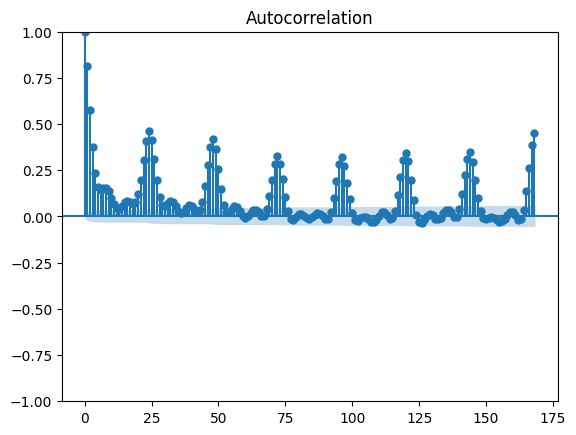

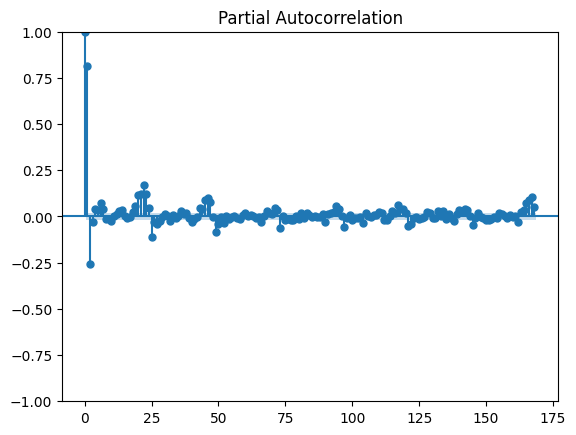

In [6]:
LAGS = 24*7

# ver si es estacionaria
acf_original = plot_acf(df["y"], lags=LAGS)
pacf_original = plot_pacf(df["y"], lags=LAGS)

In [7]:
adf_test = adfuller(df["y"])
print(f"p-value: {adf_test[1]}")	

p-value: 2.147977569211813e-20


In [8]:
# podemos aplicar transformaciones para convertir la serie en una estacionaria
df["y_log"] = df["y"].apply(np.log1p)
df["y_log_diff"] = df["y_log"].diff()
df["y_log_diff_diff"] = df["y_log_diff"].diff()

In [9]:
adf_test = adfuller(df["y_log_diff"].dropna())
print(f"p-value: {adf_test[1]}")

p-value: 0.0


In [10]:
df.dropna(inplace=True)

print(df.shape)

df.head()

(12069, 5)


,ds,y,y_log,y_log_diff,y_log_diff_diff
2,2022-07-02 02:00:00,3.000000,1.386294,0.287682,0.575364
3,2022-07-02 03:00:00,2.000000,1.098612,-0.287682,-0.575364
4,2022-07-02 04:00:00,3.055266,1.400016,0.301404,0.589086
5,2022-07-02 05:00:00,3.762832,1.560843,0.160826,-0.140578
6,2022-07-02 06:00:00,4.195265,1.647748,0.086905,-0.073921


concluimos que ahora la función es estacionaria

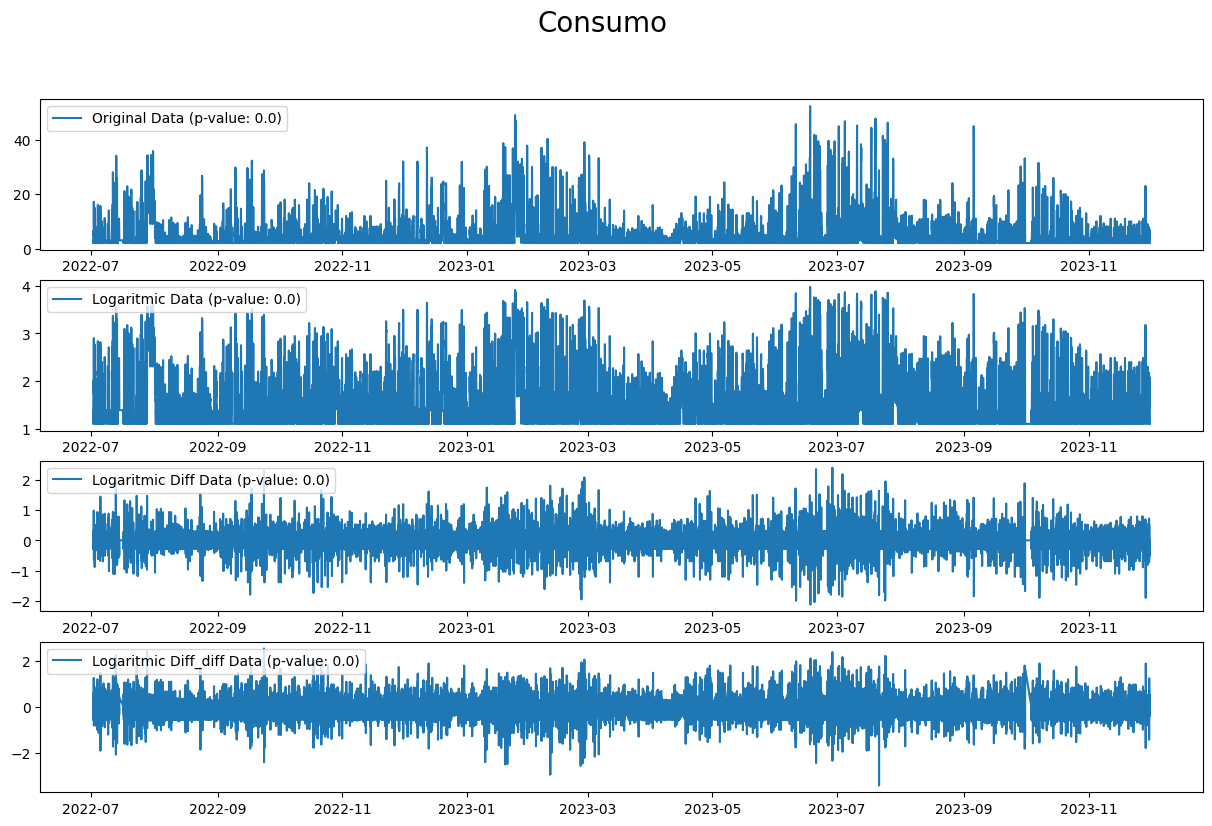

In [11]:
# instanciate the figure
fig = plt.figure(figsize = (15, 9))
ax1, ax2, ax3, ax4 = fig.subplots(4, 1)

# select x and y to plot
df_x = df["ds"]

df_y = df["y"]
df_y_log = df["y_log"]
df_y_log_diff = df["y_log_diff"]
df_y_log_diff_diff = df["y_log_diff_diff"]

# plotting part
ax1.plot(df_x, df_y, label = f"Original Data (p-value: {round(adfuller(df_y)[1], 4)})")
ax2.plot(df_x, df_y_log, label = f"Logaritmic Data (p-value: {round(adfuller(df_y_log)[1], 4)})")
ax3.plot(df_x, df_y_log_diff, label = f"Logaritmic Diff Data (p-value: {round(adfuller(df_y_log_diff.dropna())[1], 4)})")
ax4.plot(df_x, df_y_log_diff_diff, label = f"Logaritmic Diff_diff Data (p-value: {round(adfuller(df_y_log_diff_diff.dropna())[1], 4)})")

ax1.legend(loc = "upper left")
ax2.legend(loc = "upper left")
ax3.legend(loc = "upper left")
ax4.legend(loc = "upper left")

fig.suptitle("Consumo", fontsize = 20);

In [12]:
df.dropna(inplace = True)

# df.reset_index(inplace = True)


In [13]:
print(df_x.shape)
print(df_y.shape)
print(df_y.shape)
print(df_y_log.shape)
print(df_y_log_diff.shape) 

(12069,)
(12069,)
(12069,)
(12069,)
(12069,)


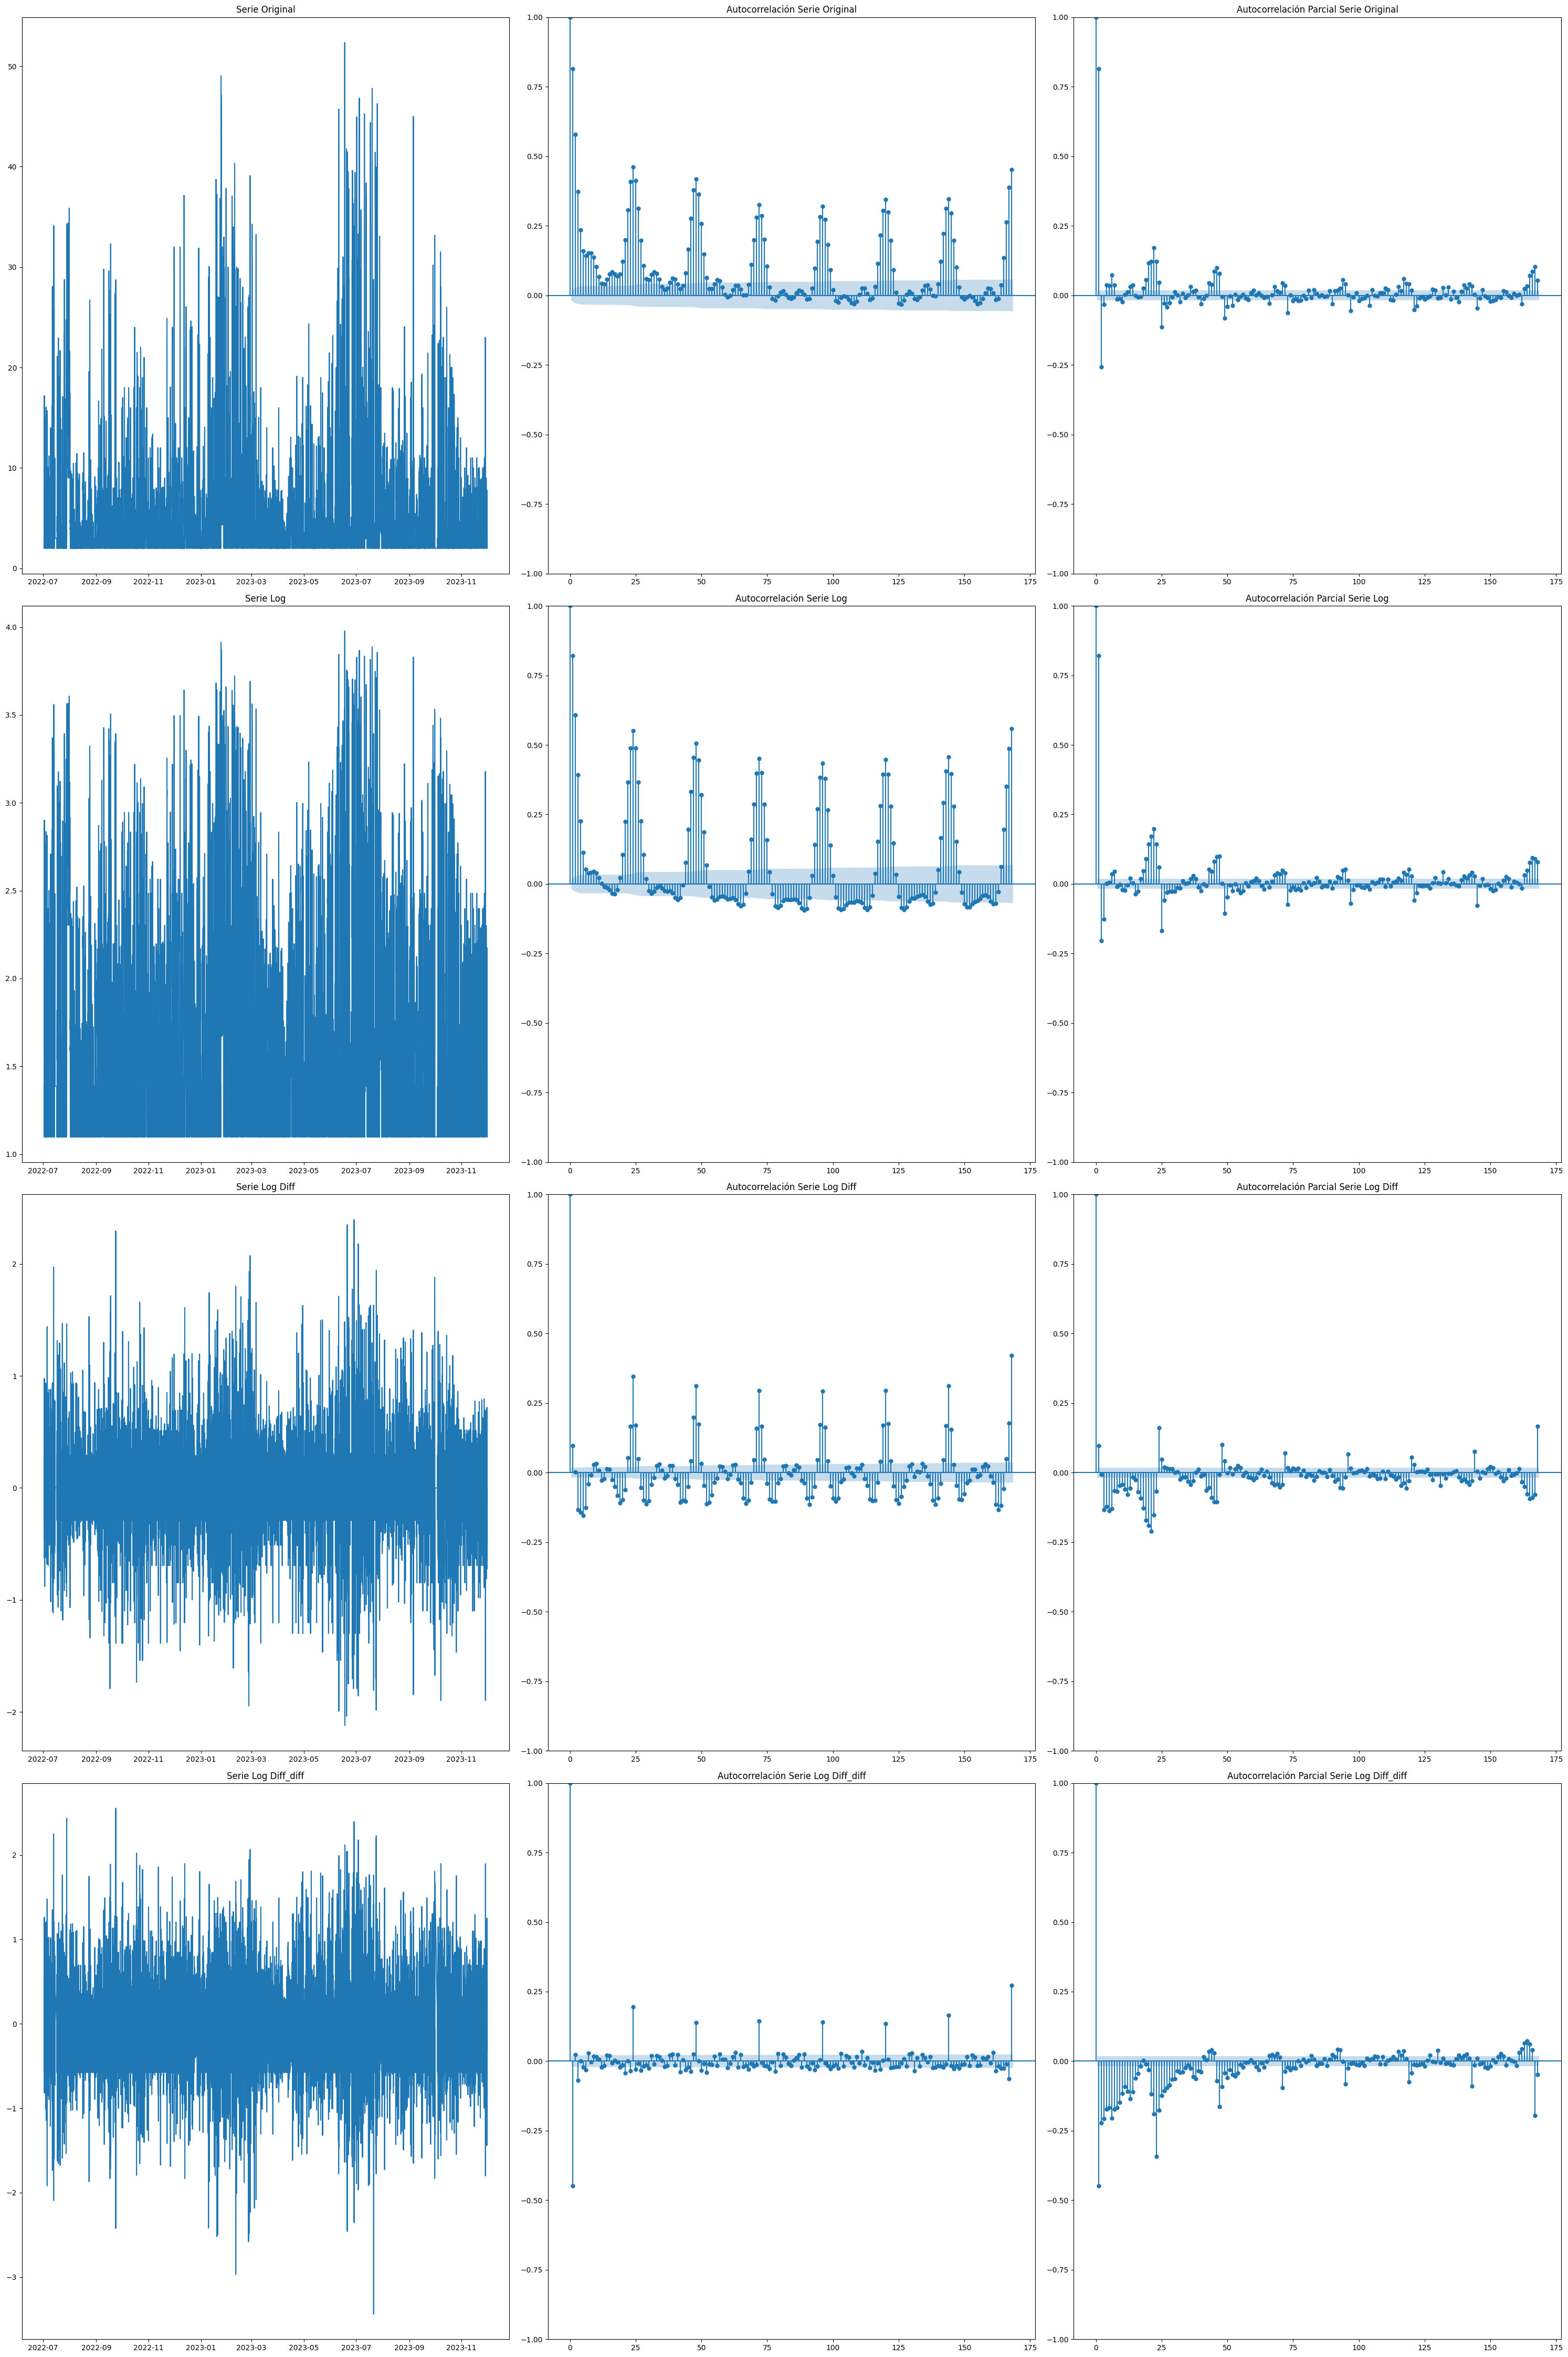

In [14]:
fig = plt.figure(figsize = (30, 45))

((ax11, ax12, ax13), (ax21, ax22, ax23), (ax31, ax32, ax33), (ax41, ax42, ax43)) = fig.subplots(4, 3)

ax11.plot(df_x, df_y)
ax11.set_title("Serie Original")
plot_acf(df_y, ax = ax12, lags = LAGS, title = "Autocorrelación Serie Original")
plot_pacf(df_y, ax = ax13, lags = LAGS, title = "Autocorrelación Parcial Serie Original")

ax21.plot(df_x, df_y_log)
ax21.set_title("Serie Log")
plot_acf(df_y_log, ax = ax22, lags = LAGS, title = "Autocorrelación Serie Log")
plot_pacf(df_y_log, ax = ax23, lags = LAGS, title = "Autocorrelación Parcial Serie Log")

ax31.plot(df_x, df_y_log_diff)
ax31.set_title("Serie Log Diff")
plot_acf(df_y_log_diff, ax = ax32, lags = LAGS, title = "Autocorrelación Serie Log Diff")
plot_pacf(df_y_log_diff, ax = ax33, lags = LAGS, title = "Autocorrelación Parcial Serie Log Diff")

ax41.plot(df_x, df_y_log_diff_diff)
ax41.set_title("Serie Log Diff_diff")
plot_acf(df_y_log_diff_diff, ax = ax42, lags = LAGS, title = "Autocorrelación Serie Log Diff_diff")
plot_pacf(df_y_log_diff_diff, ax = ax43, lags = LAGS, title = "Autocorrelación Parcial Serie Log Diff_diff")

fig.tight_layout()

# Gridsearch

In [15]:
# ts_to_predict_arima = df.copy().set_index("ds")["y_log_diff"] # usa la serie DIFERENCIADA para la predicción
ts_to_predict_arima = df.copy().set_index("ds")["y_log"]      # usa la serie LOG para la predicción

In [16]:
y_train_arima = ts_to_predict_arima[:-10]
y_test_arima = ts_to_predict_arima[-10:]

In [17]:
pdq = [
    # el primer valor es la autocorrelacion parcial, el segundo de la cantidad de diff, el tercero autocorrelacion

    (1, 0, 1),
    (1, 0, 2),
    (1, 0, 3),

    (2, 0, 1),
    (2, 0, 2),
    (2, 0, 3),

    (3, 0, 1),
    (3, 0, 2),
    (3, 0, 3),

    # (24, 0, 1),
    # (24, 0, 2),
    # (24, 0, 3),
    
    # (1, 1, 1),
    # (1, 1, 2),
    # (1, 1, 21),

    # (6, 1, 1),
    # (6, 1, 2),
    # (6, 1, 21),
 
    # (24, 1, 1),
    # (24, 1, 2),
    # (24, 1, 21)

]
  


seasonal_pdq = (0, 0, 0, 0)

In [18]:
import warnings
warnings.filterwarnings("ignore", message="An unsupported index was provided")

RESULTS_DICT = {}

for param in pdq:

    model = sm.tsa.statespace.SARIMAX(
        endog = y_train_arima,
        order = param,
        seasonal_order = seasonal_pdq,
        enforce_stationarity = False, # porque ya es una serie estacionaria
        enforce_invertibility = False # porque ya es una serie estacionaria
    )

    model_fitted = model.fit(disp=False)

    print('ARIMA{}x{}12 - AIC:{}'.format(param, seasonal_pdq, model_fitted.aic))
    
    RESULTS_DICT[param] = round(model_fitted.aic, 2)

c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1)x(0, 0, 0, 0)12 - AIC:8968.610913511484


c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 2)x(0, 0, 0, 0)12 - AIC:8947.895194950786


c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 3)x(0, 0, 0, 0)12 - AIC:8790.215780724888


c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 0, 1)x(0, 0, 0, 0)12 - AIC:8964.817812385034


c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(0, 0, 0, 0)12 - AIC:8505.074613982006


c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 3)x(0, 0, 0, 0)12 - AIC:9240.512047596987


c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 1)x(0, 0, 0, 0)12 - AIC:nan


c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(3, 0, 2)x(0, 0, 0, 0)12 - AIC:8153.363191510903


c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\OneDrive - IREC-edu\WP4\WP4\envWP4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(3, 0, 3)x(0, 0, 0, 0)12 - AIC:7491.501957020461


In [19]:
# gridsearch x y gridsearch y
gsx = list(map(str, list(RESULTS_DICT.keys())))
gsy = list(RESULTS_DICT.values())

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


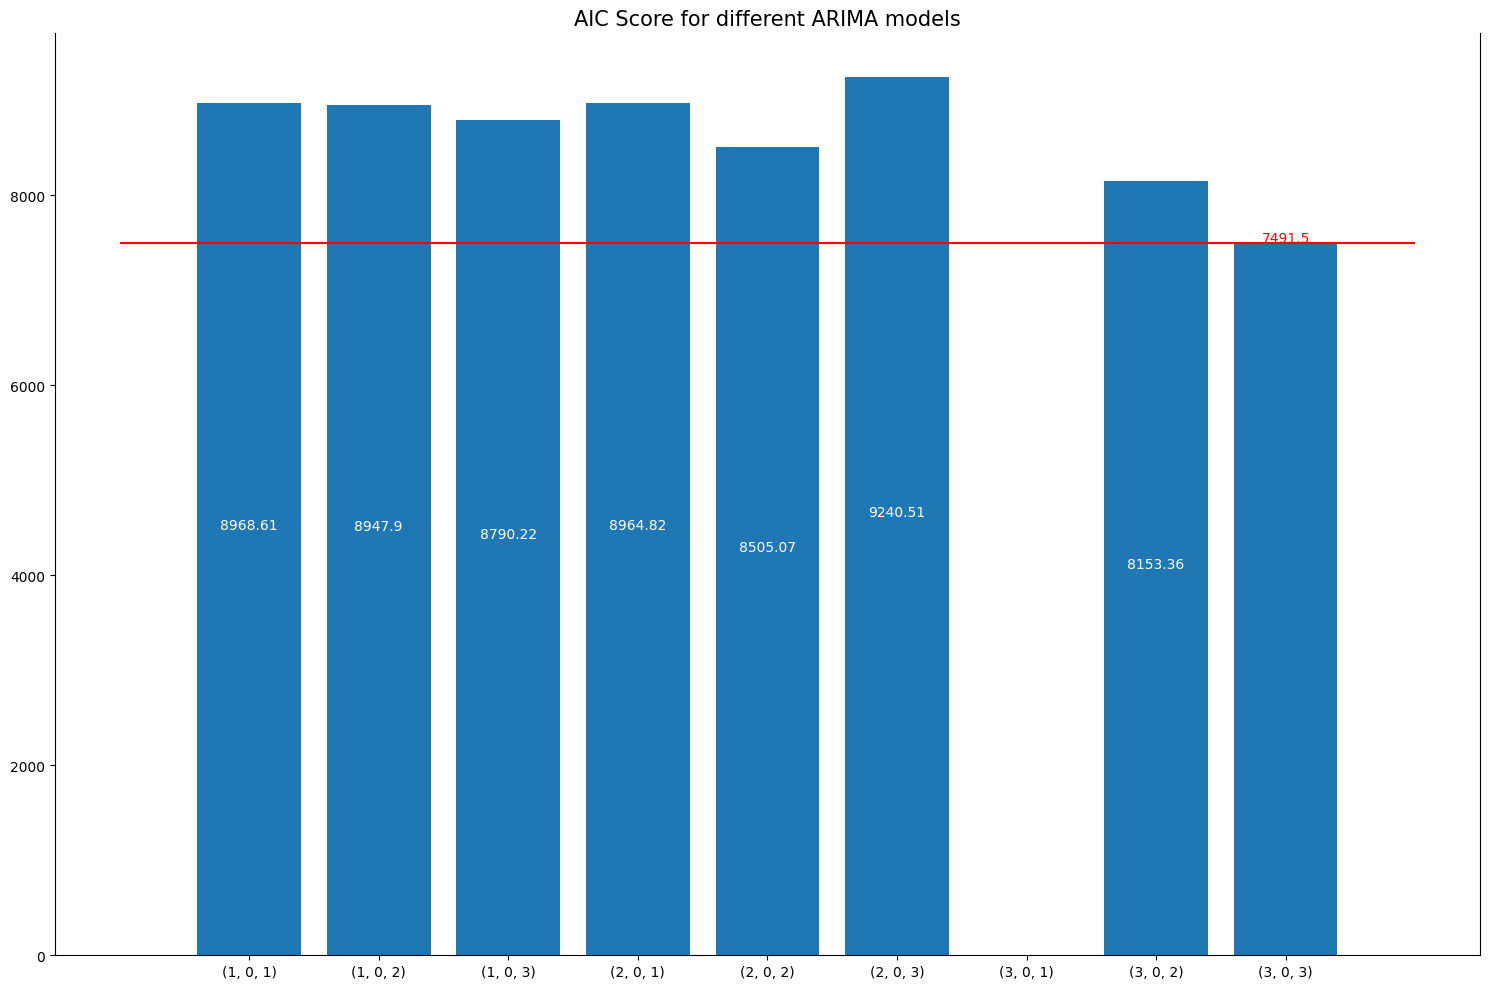

In [20]:
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot()

ax.bar(x = gsx, height = gsy)
ax.hlines(y = min(gsy), xmin = -1, xmax = len(gsx), color = "red")

for xtick_, y_ in zip(gsx, gsy):
    
    s_ = str(round(y_, 2))
    
    ax.text(
        x = xtick_, 
        y = y_/2 if y_ != min(gsy) else y_ + 10, 
        s = s_, 
        ha = "center", 
        color = "red" if y_ == min(gsy) else "white"
    )

ax.spines["top"].set_color("None")

plt.title(label = "AIC Score for different ARIMA models", fontsize = 15)
plt.tight_layout()

In [21]:
idx_min_score_aic = np.argmin(list(RESULTS_DICT.values()))
pdq_min_score_aic = list(RESULTS_DICT.keys())[idx_min_score_aic]
min_score_aic = RESULTS_DICT[pdq_min_score_aic]

message = f'''
El score mínimo se alcanza con ARIMA{pdq_min_score_aic}
Con un score AIC de {min_score_aic}.
En la posición {idx_min_score_aic}
'''

print(message)


El score mínimo se alcanza con ARIMA(3, 0, 1)
Con un score AIC de nan.
En la posición 6



In [22]:
prkdf

NameError: name 'prkdf' is not defined

# Fit

In [ ]:
best_arima_model = sm.tsa.statespace.SARIMAX(
    endog = y_train_arima,
    order = (3,0,3),#pdq_min_score_aic,
    seasonal_order = seasonal_pdq,
    enforce_stationarity = False,
    enforce_invertibility = False
)

best_arima_model_fitted = best_arima_model.fit()

: 

In [ ]:
print(best_arima_model_fitted.summary().tables[1])

: 

In [ ]:
best_arima_model_fitted.plot_diagnostics(figsize = (15, 12), lags = 3);

: 

In [ ]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = best_arima_model_fitted.get_forecast(steps = len(y_test_arima))
y_pred_arima = pred_uc.predicted_mean

: 

In [ ]:
y_pred_arima

: 

In [ ]:
fig = plt.figure(figsize = (12, 6))
ax = fig.subplots()

ax.plot(ts_to_predict_arima, label = "True Values")
ax.plot(y_pred_arima, label = "ARIMA Forecast")

ax.legend(loc = "upper left")
fig.suptitle("ARIMA Forecast", fontsize = 15)

: 